In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


Para evitar el sesgo de supervivencia (debido a que mi backtest lo voy a hacer con una ventana de 11 meses), en un archivo de Excel liste todas las compañias del indice Nasdaq, incluyendo las que fueron deslistadas en el último rebalanceo en diciembre de 2020. En este link se puede encontrar las compañias que se listaron y se deslistaron: https://www.globenewswire.com/news-release/2020/12/12/2144096/0/en/Annual-Changes-to-the-Nasdaq-100-Index.html

In [2]:
companies_df = pd.read_excel('Nasdaq 100 companies.xlsx') #importo el archivo de excel con las compañias del indice
tickers = companies_df.Symbol.to_list() #creo una lista con los tickers 

Para efectos de menor extension el código, mi estrategia la voy a ejecutar a tráves de una función. Como se describió en el taller 2, la estrategia que escogí consiste en calcular el TSI para todas las compañias (tomando informacion del último mes) e irme largo en la 5 compañias con mayor TSI.

Lo que quiero de la funcion que programaré es que el output sea simplemente una lista con los tickers de las 5 compañias con mayor TSI.

Es importante mencionar que cada paso dentro de la función lo observe separadamente para observar que los cálculos fueran correctos, sin embargo como este es el notebook final decidi hacer todos los pasos dentro de una función por organización y eficiencia

In [3]:
def momentum(start_date, close_date):
    data = pd.DataFrame() #creo un data frame para la info del precio de cierre diario durante el último mes
    for stock in tickers:
        data[stock] = wb.DataReader(stock,data_source='yahoo',start=start_date,end=close_date)['Close'] #traigo la información al dataframe por medio de un loop
    PC = data - data.shift(1) # calculo el cambio en el precio de cierre diario
    Smooth_PC_25 = PC.ewm(span=25,adjust=False).mean() #calculo el EWMA de 25 dias del cambio en el precio
    D_Smooth_PC_13 = Smooth_PC_25.ewm(span=13,adjust=False).mean() #calculo el EWMA de 13 dias del EWMA de 25 dias
    ABS_PC = PC.abs() #calculo el cambio absoluto en el precio de cierre diario
    Smooth_ABS_PC_25 = ABS_PC.ewm(span=25,adjust=False).mean() # calculo el EWMA d 25 dias del cambio absoluto en el precio
    D_Smooth_ABS_PC_13 = Smooth_ABS_PC_25.ewm(span=13,adjust=False).mean() # calculo el EWMA DE 13 del EWMA anterior
    TSI = 100 * (D_Smooth_PC_13/D_Smooth_ABS_PC_13) # calculo el TSI
    TSI_last = TSI.iloc[-1] # guardo los últimos TSI disponibles
    Buy = TSI_last.nlargest(5,"last") # escogo las 5 acciones con mayor TSI
    stocks_to_buy = pd.DataFrame(data=Buy).T 
    tickers_to_buy = stocks_to_buy.columns # guado en una lista los tickers
    return tickers_to_buy

Mi idea es que el primer dia de cada mes pueda correr esta función para observar en cuales acciones me deberia ir largo. Para ver como funciona el codigo voy a correrlo para ver en que acciones me deberia ir largo el 1 de mayo de 2021.

In [4]:
momentum('2021-04-01','2021-04-30')

Index(['GOOG', 'GOOGL', 'XEL', 'VRSN', 'IDXX'], dtype='object')

Como se puede observar, los inputs de la función son las fechas de 1 de abril y el 30 de abril de 2021 (último mes disponible antes de la fecha en que quiero observar en que acciones me quiero ir largo)

Mi idea para el backtesting es correr la estrategia en una ventana de 11 meses, y calcular los retornos de cada activo que la estrategia hubieron escogido para ver si ha funcionado o no.

In [18]:
returns = []
long_on = []
def accuracy(start_date,close_date,start_d_t,close_d_t):
    long_on = list(momentum(start_date,close_date))
    data_bt = pd.DataFrame()
    for stock in long_on:
        data_bt[stock] = wb.DataReader(stock,data_source='yahoo',start=start_d_t,end=close_d_t)['Close']
    rt = (data_bt.iloc[-1]-data_bt.iloc[0])/data_bt.iloc[0]
    returns = np.round(list(rt),decimals = 4)
    return long_on, returns        

In [19]:
accuracy('2021-03-01','2021-03-31','2021-04-01','2021-04-30')

(['EXC', 'ORLY', 'FOXA', 'FOX', 'PEP'],
 array([0.0235, 0.0887, 0.0306, 0.0394, 0.0204]))

Voy a explicar lo que esta haciendo la función accuracy. Los dos primeros inputs son las fechas del último mes disponible para escoger las acciones en largo. Los otros dos inputs son las fechas del mes donde se escogieron las acciones para ver si efectivamente el precio de las acciones elegidas aumentó. 

Lo que esta pasando es que se está replicando la estrategia y viendo si fue efectiva. Es muy importante aclarar que no se está efectuando "look ahead bias" porque es con la información del mes anterior que se escogen las acciones donde despues se observa si los precios de estas acciones subieron o bajaron al final del mes.

Por ejemplo para este caso las acciones que se hubieran elegido el 1 de abril de 2021 (como se ve en los dos primeros inputs se uso el mes de marzo para elegir esas acciones) todas tuvieron retornos positivos.

Ahora solo queda correr la función de accuracy para todas las ventanas y observar los resultados.


In [20]:
accuracy('2021-02-01','2021-02-28','2021-03-01','2021-03-31')

(['EXPE', 'MAR', 'TCOM', 'BKNG', 'WDAY'],
 array([ 0.0675, -0.0024, -0.0033,  0.004 , -0.0173]))

In [21]:
accuracy('2021-01-01','2021-01-31','2021-02-01','2021-02-28')

(['LBTYK', 'LBTYA', 'ILMN', 'JD', 'PDD'],
 array([ 0.01  ,  0.025 , -0.009 ,  0.0285, -0.0161]))

In [22]:
accuracy('2020-12-01','2020-12-31','2021-01-01','2021-01-31')

(['BIDU', 'TTWO', 'ISRG', 'CDNS', 'EA'],
 array([ 0.084 , -0.0069, -0.0654, -0.0396,  0.0264]))

In [23]:
accuracy('2020-11-01','2020-11-30','2020-12-01','2020-12-31')

(['CMCSA', 'KLAC', 'LRCX', 'MU', 'PEP'],
 array([0.027 , 0.0088, 0.0099, 0.1208, 0.0153]))

In [24]:
accuracy('2020-10-01','2020-10-31','2020-11-01','2020-11-30')

(['AEP', 'ADP', 'EXC', 'ALGN', 'SPLK'],
 array([-0.0695,  0.0769,  0.0027,  0.0498,  0.0671]))

In [25]:
accuracy('2020-09-01','2020-09-30','2020-10-01','2020-10-31')

(['AEP', 'SGEN', 'ALGN', 'MU', 'CDW'],
 array([ 0.0827, -0.1571,  0.3415,  0.0505, -0.0073]))

In [26]:
accuracy('2020-08-01','2020-08-31','2020-09-01','2020-09-30')

(['CPRT', 'TXN', 'COST', 'CHTR', 'MAR'],
 array([ 0.011 , -0.015 ,  0.0103,  0.0115, -0.1019]))

In [27]:
accuracy('2020-07-01','2020-07-31','2020-08-01','2020-08-31')

(['PCAR', 'FAST', 'VRSK', 'XLNX', 'DOCU'],
 array([ 0.0027,  0.0295, -0.0016, -0.021 , -0.0145]))

In [28]:
accuracy('2020-06-01','2020-06-30','2020-07-01','2020-07-31')

(['PTON', 'QCOM', 'TXN', 'EBAY', 'ASML'],
 array([ 0.1323,  0.1763,  0.022 ,  0.0438, -0.0377]))

In [30]:
accuracy('2020-05-01','2020-05-31','2020-06-01','2020-06-30')

(['TSLA', 'EBAY', 'OKTA', 'CDNS', 'ADSK'],
 array([ 0.2023,  0.1604, -0.0222,  0.0467,  0.0907]))

Es importante comparar los retornos de la estrategia con un benchmark, porque aunque la estrategia funcione (obtenga retornos positivos), puede pasar que esos retornos no sean mayores a los del mercado, haciendo que la estrategia sea ineficiente.

El benchmark que elegire es el indice SP500. 

In [69]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt

A continuación calcularé los retornos mensuales del S&P 500 durante la ventana escogida.

In [70]:
SP_ticker = ['^GSPC']
def monthly_returns_SP(start,close):
    data_sp = pd.DataFrame()
    for stock in SP_ticker:
        data_sp[stock] = wb.DataReader(stock,data_source='yahoo',start=start,end=close)['Close']
        ret = (data_sp.iloc[-1]-data_sp.iloc[0])/data_sp.iloc[0]
        ret_array = np.round(ret,decimals = 4)
    return ret_array    

In [71]:
monthly_returns_SP('2021-04-01','2021-04-30')

^GSPC    0.0401
dtype: float64

In [72]:
monthly_returns_SP('2021-03-01','2021-03-31')

^GSPC    0.0182
dtype: float64

In [73]:
monthly_returns_SP('2021-02-01','2021-02-28')

^GSPC    0.0099
dtype: float64

In [74]:
monthly_returns_SP('2021-01-01','2021-01-31')

^GSPC    0.0037
dtype: float64

In [75]:
monthly_returns_SP('2020-12-01','2020-12-31')

^GSPC    0.0256
dtype: float64

In [76]:
monthly_returns_SP('2020-11-01','2020-11-30')

^GSPC    0.0941
dtype: float64

In [77]:
monthly_returns_SP('2020-10-01','2020-10-31')

^GSPC   -0.0328
dtype: float64

In [78]:
monthly_returns_SP('2020-09-01','2020-09-30')

^GSPC   -0.0464
dtype: float64

In [79]:
monthly_returns_SP('2020-08-01','2020-08-31')

^GSPC    0.0624
dtype: float64

In [80]:
monthly_returns_SP('2020-07-01','2020-07-31')

^GSPC    0.0498
dtype: float64

In [81]:
monthly_returns_SP('2020-06-01','2020-06-30')

^GSPC    0.0146
dtype: float64

In [82]:
Date = ['2020-06-30','2020-07-31','2020-08-31','2020-09-30','2020-10-31','2020-11-30','2020-12-31','2021-01-31','2021-02-28','2021-03-31','2021-04-30']
SP_returns = [0.0146,0.0498,0.0624,-0.0464,-0.0328,0.0941,0.0256,0.0037,0.0099,0.0182,0.0401]
Strategy_returns = [0.4779,0.3367,-0.0049,-0.0841,0.3103,0.127,0.1818,-0.0015,0.0384,0.0485,0.2026]

returns_paired = [[0.0146,0.4779],
            [0.0498,0.3367],
            [0.0624,-0.0049],
            [-0.0464,-0.0841],
            [-0.0328,0.3103],
                 [0.0941,0.127],
                 [0.0256,0.1818],
                 [0.0037,-0.0015],
                 [0.0099,0.0384],
                 [0.0182,0.0485],
                 [0.0401,0.2026]]
df_returns = pd.DataFrame(returns_paired, columns = [ 'SP500', 'Estrategia'], index=Date)
df_returns

,SP500,Estrategia
2020-06-30,0.0146,0.4779
2020-07-31,0.0498,0.3367
2020-08-31,0.0624,-0.0049
2020-09-30,-0.0464,-0.0841
2020-10-31,-0.0328,0.3103
2020-11-30,0.0941,0.1270
2020-12-31,0.0256,0.1818
2021-01-31,0.0037,-0.0015
2021-02-28,0.0099,0.0384
2021-03-31,0.0182,0.0485


Como se puede observar solo en 3 ocasiones los retornos del S&P500 fueron superiores a los de  la estrategia.

Voy a crear un grafico que compare los retornos mensuales de la estrategia vs el S&P500

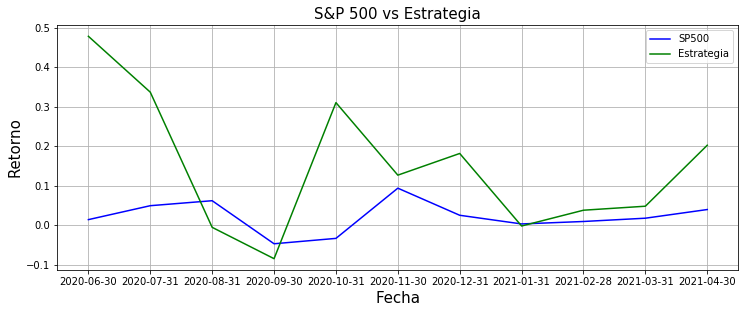

In [83]:
plt.figure(figsize=(12.2,4.5))
plt.title('S&P 500 vs Estrategia',fontsize=15)
plt.xlabel('Fecha', fontsize=15)
plt.ylabel('Retorno', fontsize=15)
plt.plot(df_returns['SP500'], label = 'SP500', color ='blue')
plt.plot(df_returns['Estrategia'], label = 'Estrategia', color ='green')
plt.legend()
plt.grid()
plt.show()

Ahora también es importante observar la volatilidad de la estrategia y compararla con la del S&P500. A continuacion efectua el cálculo de la volatilidad mensual.

In [84]:
tick1 = ['TSLA', 'EBAY', 'OKTA', 'CDNS', 'ADSK']
tick2 = ['PTON', 'QCOM', 'TXN', 'EBAY', 'ASML']
tick3 = ['PCAR', 'FAST', 'VRSK', 'XLNX', 'DOCU']
tick4 = ['CPRT', 'TXN', 'COST', 'CHTR', 'MAR']
tick5 = ['AEP', 'SGEN', 'ALGN', 'MU', 'CDW']
tick6 = ['AEP', 'ADP', 'EXC', 'ALGN', 'SPLK']
tick7 = ['CMCSA', 'KLAC', 'LRCX', 'MU', 'PEP']
tick8 = ['BIDU', 'TTWO', 'ISRG', 'CDNS', 'EA']
tick9 = ['LBTYK', 'LBTYA', 'ILMN', 'JD', 'PDD']
tick10 = ['EXPE', 'MAR', 'TCOM', 'BKNG', 'WDAY']
tick11 = ['EXC', 'ORLY', 'FOXA', 'FOX', 'PEP']
tick_bench = ['^GSPC']

In [85]:
def volatility(tick,startd,closed,window):
    data_vol = pd.DataFrame()
    for stock in tick:
        data_vol[stock] = wb.DataReader(stock,data_source='yahoo',start=startd,end=closed)['Close']
    returns_t = np.log(data_vol/data_vol.shift(1))
    var = returns_t.var()*window
    var_tot = sum(var)
    vol = np.round(np.sqrt(var_tot),decimals = 4)
    return vol

In [86]:
volatility(tick1,'2020-06-01','2020-06-30',29)

0.3186

In [87]:
volatility(tick2,'2020-07-01','2020-07-31',30)

0.3625

In [88]:
volatility(tick3,'2020-08-01','2020-08-31',30)

0.1824

In [89]:
volatility(tick4,'2020-09-01','2020-09-30',29)

0.2391

In [90]:
volatility(tick5,'2020-10-01','2020-10-31',30)

0.4517

In [91]:
volatility(tick6,'2020-11-01','2020-11-30',29)

0.2309

In [92]:
volatility(tick7,'2020-12-01','2020-12-31',30)

0.1746

In [93]:
volatility(tick8,'2021-01-01','2021-01-31',30)

0.3879

In [94]:
volatility(tick9,'2021-02-01','2021-02-28',27)

0.3245

In [95]:
volatility(tick10,'2021-03-01','2021-03-31',30)

0.3087

In [96]:
volatility(tick11,'2021-04-01','2021-04-30',29)

0.1111

ahora calculamos las volatilidades mensuales del SP500

In [97]:
volatility(tick_bench,'2020-06-01','2020-06-30',29)

0.1035

In [98]:
volatility(tick_bench,'2020-07-01','2020-07-31',30)

0.0468

In [99]:
volatility(tick_bench,'2020-08-01','2020-08-31',30)

0.0282

In [100]:
volatility(tick_bench,'2020-09-01','2020-09-30',29)

0.0856

In [101]:
volatility(tick_bench,'2020-10-01','2020-10-31',30)

0.0737

In [102]:
volatility(tick_bench,'2020-11-01','2020-11-30',29)

0.0551

In [103]:
volatility(tick_bench,'2020-12-01','2020-12-31',30)

0.0279

In [104]:
volatility(tick_bench,'2021-01-01','2021-01-31',30)

0.0575

In [105]:
volatility(tick_bench,'2021-02-01','2021-02-28',27)

0.0445

In [106]:
volatility(tick_bench,'2021-03-01','2021-03-31',30)

0.0519

In [107]:
volatility(tick_bench,'2021-04-01','2021-04-30',29)

0.0357

In [112]:
Date = ['2020-06-30','2020-07-31','2020-08-31','2020-09-30','2020-10-31','2020-11-30','2020-12-31','2021-01-31','2021-02-28','2021-03-31','2021-04-30']
SP_vol = [0.1035,0.0468,0.0282,0.0856,0.0737,0.0551,0.0279,0.0575,0.0445,0.0519,0.0357]
Strategy_vol = [0.3186,0.3625,0.1824,0.2391,0.4517,0.2309,0.1746,0.3819,0.3245,0.3087,0.1111]

vol_paired = [[0.1035,0.3186],
            [0.0468,0.3625],
            [0.0282,0.1824],
            [0.0856,0.2391],
            [0.0737,0.4517],
                 [0.0551,0.2309],
                 [0.0279,0.1746],
                 [0.0575,0.3819],
                 [0.0445,0.3245],
                 [0.0519,0.3087],
                 [0.0357,0.1111]]
df_vol = pd.DataFrame(vol_paired, columns = [ 'SP500', 'Estrategia'], index=Date)
df_vol

,SP500,Estrategia
2020-06-30,0.1035,0.3186
2020-07-31,0.0468,0.3625
2020-08-31,0.0282,0.1824
2020-09-30,0.0856,0.2391
2020-10-31,0.0737,0.4517
2020-11-30,0.0551,0.2309
2020-12-31,0.0279,0.1746
2021-01-31,0.0575,0.3819
2021-02-28,0.0445,0.3245
2021-03-31,0.0519,0.3087


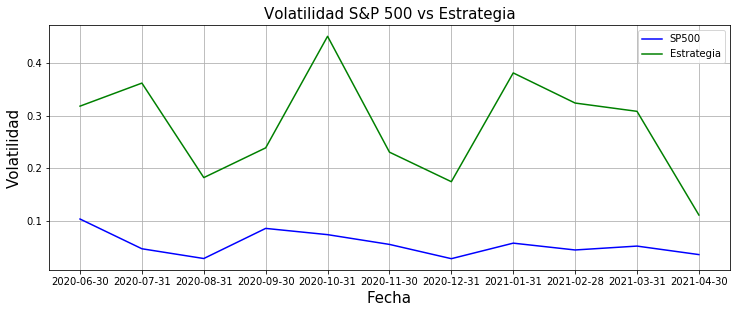

In [113]:
plt.figure(figsize=(12.2,4.5))
plt.title('Volatilidad S&P 500 vs Estrategia',fontsize=15)
plt.xlabel('Fecha', fontsize=15)
plt.ylabel('Volatilidad', fontsize=15)
plt.plot(df_vol['SP500'], label = 'SP500', color ='blue')
plt.plot(df_vol['Estrategia'], label = 'Estrategia', color ='green')
plt.legend()
plt.grid()
plt.show()

Finalmente voy a calcular el retorno y volatilidad promedio de la estartegia durante los 11 meses, y compararlo con el del mercado

In [119]:
Ret = df_returns.mean()
Ret

SP500         0.021745
Estrategia    0.148427
dtype: float64

In [120]:
Vol =df_vol.mean()
Vol

SP500         0.055491
Estrategia    0.280545
dtype: float64